In [6]:
# manual energy range

from astropy.io import fits
from astropy.table import Table

original_data_path = "simulated_data/0374_const_bkg/2_0"

new_data_path = "simulated_data/manual_energy_range"

min_index = 64

with fits.open(f"{original_data_path}/evts_det_spec.fits") as f:
    t = Table.read(f[1])
    
t["COUNTS"] = t["COUNTS"][:,min_index:]
d = t


hdu = fits.BinTableHDU(data=d, name="SPI.-OBS.-DSP")
hdu.writeto(f"{new_data_path}/evts_det_spec.fits")

with fits.open(f"{original_data_path}/energy_boundaries.fits") as f:
    t = Table.read(f[1])
d = t[min_index:]


hdu = fits.BinTableHDU(data=d, name="SPI.-OBS.-DSP")
hdu.writeto(f"{new_data_path}/energy_boundaries.fits")



In [21]:
# background comparison plotter

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table
from datetime import datetime
import astropy.time as at
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum
from astromodels import Powerlaw,  PointSource, SpectralComponent

data_path = "crab_data/0374"
data_path_smf = "crab_data/0374_spimodfit_bkg"
data_path_smf_bkg = "crab_data/0374_spimodfit_bkg/bg-e0020-0600"


# real data
pointing_index = 1

with fits.open(f"{data_path}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])
    
print(pointings[pointing_index])
    
with fits.open(f"{data_path}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{data_path}/evts_det_spec_orig.fits") as file:
    t = Table.read(file[1])
    counts = t["COUNTS"]
    
with fits.open(f"{data_path}/dead_time.fits") as file:
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

time = time_start[pointing_index]
version = find_response_version(time)
rsp_base = ResponseDataRMF.from_version(version)
dets = get_live_dets(time=time, event_types=["single"])

print(dets)

indices = [pointing_index*85 + i for i in dets]
background_counts = counts[indices]
background_counts_max = np.amax(background_counts, axis=0)
background_counts_min = np.amin(background_counts, axis=0)
background_counts_mean = np.average(background_counts, axis=0)



ra, dec = 10, -40
K, piv, index = 0.0045, 40, -2
    
pl = Powerlaw()
pl.piv = piv
pl.K = K
pl.index = index
component1 = SpectralComponent("pl", shape=pl)
source = PointSource("Test", ra=ra, dec=dec, components=[component1])

emod = np.geomspace(10, 3000, 50)
spec = source(emod)
spec_binned = powerlaw_binned_spectrum(emod, spec)

rmfs = []
for d in dets:
    rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))

sds = np.empty(0)
for d in range(len(dets)):
    sd = SPIDRM(rmfs[d], ra, dec)
    sds = np.append(sds, sd.matrix.T)
resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))

count_rates = np.dot(spec_binned, resp_mat)

source_counts = np.zeros((len(dets), len(energy_bins)-1))
for d_i, d in enumerate(dets):
    index = pointing_index * 85 + d
    source_counts[d_i,:] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])

source_counts_max = np.amax(source_counts, axis=0)
source_counts_min = np.amin(source_counts, axis=0)
source_counts_mean = np.average(source_counts, axis=0)



# smf data
with fits.open(f"{data_path_smf}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings_smf = np.array(t["PTID_SPI"])
    
    time_start_smf = np.array(t["TSTART"]) + 2451544.5
    time_start_smf = [at.Time(f"{i}", format="jd").datetime for i in time_start_smf]
    time_start_smf = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start_smf])
    
print(pointings_smf[pointing_index])
    
with fits.open(f"{data_path_smf}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    energy_bins_smf = np.append(t["E_MIN"], t["E_MAX"][-1])
    
    
with fits.open(f"{data_path_smf}/dead_time.fits") as file:
    t = Table.read(file[1])
    time_elapsed_smf = np.array(t["LIVETIME"])
    
e_indices = []
for e in energy_bins_smf:
    temp = np.argwhere(energy_bins==e)
    if len(temp)>0:
        e_indices.append(temp[0][0])
        
# print(energy_bins_smf)

binned_background_counts = np.empty((len(dets), len(e_indices)-1))
for i in range(len(e_indices)-1):
    binned_background_counts[:,i] = np.sum(background_counts[ : , e_indices[i] : e_indices[i+1]], axis=1)
    
binned_background_counts_max = np.amax(binned_background_counts, axis=0)
binned_background_counts_min = np.amin(binned_background_counts, axis=0)
binned_background_counts_mean = np.average(binned_background_counts, axis=0)

with fits.open(f"{data_path_smf_bkg}/output_bgmodel-conti.fits.gz") as file:
    t = Table.read(file[1])
    conti = t["COUNTS"]
with fits.open(f"{data_path_smf_bkg}/output_bgmodel-lines.fits.gz") as file:
    t = Table.read(file[1])
    lines = t["COUNTS"]



smf_indices = [19*pointing_index + i for i in dets]

# print(lines[smf_indices])
# print(conti[smf_indices])
# print(binned_background_counts)
# print(time_elapsed[smf_indices])

smf_background_counts = (np.random.poisson(np.abs(lines[smf_indices])) * np.sign(lines[smf_indices])
                        + np.random.poisson(np.abs(conti[smf_indices])) * np.sign(conti[smf_indices]))
smf_background_counts_max = np.amax(smf_background_counts, axis=0)
smf_background_counts_min = np.amin(smf_background_counts, axis=0)
smf_background_counts_mean = np.average(smf_background_counts, axis=0)

fig, ax = plt.subplots(nrows=2, figsize=(8,8))

ax[0].step(energy_bins[:-1], background_counts_mean, color="r", where="post", label="Real Background")
ax[0].fill_between(energy_bins[:-1], background_counts_min, background_counts_max, step="post", color="r", alpha=0.3)
# plt.step(energy_bins[:-1], background_counts_min, color="r", lw=0.1, alpha=0.3)
# plt.step(energy_bins[:-1], background_counts_max, color="r", lw=0.1, alpha=0.3)

ax[0].step(energy_bins[:-1], source_counts_mean, color="g", where="post", label="Simulated Crab-like Source")
ax[0].fill_between(energy_bins[:-1], source_counts_min, source_counts_max, step="post", color="g", alpha=0.3)

ax[0].set_yscale("symlog")
ax[1].set_yscale("log")

plt.xlabel("Energy [keV]")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Counts")



ax[1].step(energy_bins_smf[:-1], binned_background_counts_mean, color="r", where="post", label="Real Background")
ax[1].step(energy_bins_smf[-2:], np.repeat(binned_background_counts_mean[-1], 2), color="r", where="post")
ax[1].fill_between(energy_bins_smf[:-1], binned_background_counts_min, binned_background_counts_max, step="post", color="r", alpha=0.3)
ax[1].fill_between(energy_bins_smf[-2:], 
                   np.repeat(binned_background_counts_min[-1], 2), 
                   np.repeat(binned_background_counts_max[-1], 2), 
                   step="post", color="r", alpha=0.3)

ax[1].step(energy_bins_smf[:-1], smf_background_counts_mean, color="b", where="post", label="Spimodfit Background")
ax[1].step(energy_bins_smf[-2:], np.repeat(smf_background_counts_mean[-1], 2), color="b", where="post")
ax[1].fill_between(energy_bins_smf[:-1], smf_background_counts_min, smf_background_counts_max, step="post", color="b", alpha=0.3)
ax[1].fill_between(energy_bins_smf[-2:], 
                   np.repeat(smf_background_counts_min[-1], 2), 
                   np.repeat(smf_background_counts_max[-1], 2), 
                   step="post", color="b", alpha=0.3)

ax[0].legend()
ax[1].legend()


path_d = "simulated_data/background_analysis"
if not os.path.exists(f"{path_d}"):
    os.mkdir(f"{path_d}")
    
plt.savefig(f"{path_d}/background.pdf")



Using the irfs that are valid between Start and 03/07/06 06:00:00 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 03/07/06 06:00:00 and 04/07/17 08:20:06 (YY/MM/DD HH:MM:SS)


KeyboardInterrupt: 

[1.12201338 1.09489751 1.03761901 0.95201315 0.95777787 0.88787592
 1.05215898 1.11214996 0.99652114 1.10413206 0.93520655 1.07502096
 1.06887798 1.00240612 0.94973161 0.91848122 0.99185633 1.1622899
 0.92765056 0.98995123]
[0.99003054 0.99875288 1.11106995 1.10201619 1.01308434 1.02936727
 1.03461101 0.96489967 1.24907767 0.94360869 0.85477652 0.8566684
 0.974153   1.10514312 0.89625772 1.11592245 1.11205023 0.91717253
 0.8947889  1.00240511]
[3.02121744 2.03047398 3.50494821 3.47197948 3.15056991 2.81013997
 1.78144764 2.8749642  1.85039326 6.02406724 3.59396538 2.25276264
 1.39291458 2.93139005 1.00957599 0.99719908 1.01891276 1.0416283
 2.35786973 3.01072895 3.14005552 5.0938819  1.11418717 1.00189806
 3.63138835 0.9990296 ]
[2.03047398 3.50494821 3.47197948 3.15056991 2.81013997 1.78144764
 2.8749642  1.85039326 6.02406724 3.59396538 2.25276264 1.39291458
 2.93139005 2.35786973 3.01072895 3.14005552 5.0938819  3.63138835]


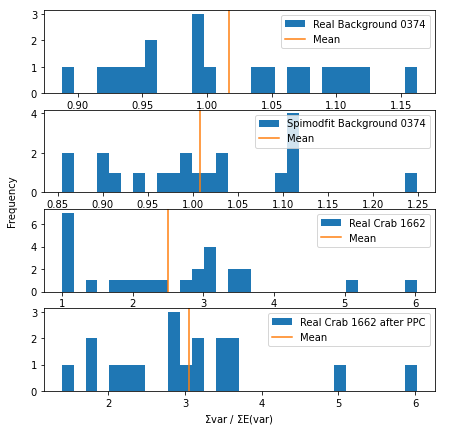

In [14]:
# background spread comparison

import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
from datetime import datetime
import astropy.time as at
from pyspi.utils.function_utils import find_response_version
# from pyspi.utils.response.spi_response_data import ResponseDataRMF
# from pyspi.utils.response.spi_response import ResponseRMFGenerator
# from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
import pickle
# from MultinestClusterFit import powerlaw_binned_spectrum
# from astromodels import Powerlaw,  PointSource, SpectralComponent

np.random.seed(0)

path_c = "sim_source_0374_w_smf_bkg"
path_r = "crab_data/0374"
path_smf = "crab_data/0374_spimodfit_bkg"
path_smf_p = "crab_data/0374_spimodfit"

with open(f"./{path_c}/pointings.pickle", "rb") as f:
    d = pickle.load(f)
    

with fits.open(f"{path_r}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])

assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
version = find_response_version(time_start[0])
dets = get_live_dets(time=time_start[0], event_types=["single"])

r_indices = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    r_indices.append(t)
    
r_indices = np.array(r_indices)
    
with fits.open(f"{path_smf_p}/pointing.fits.gz") as file:
    t = Table.read(file[1])
    
    pointings_smf = np.array(t["PTID_SPI"])

smf_indices = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings_smf):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    smf_indices.append(t)
    
smf_indices = np.array(smf_indices)

with fits.open(f"{path_r}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    r_e_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{path_smf}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    smf_e_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{path_r}/dead_time.fits") as file:
    t = Table.read(file[1])
    r_time_elapsed = np.array(t["LIVETIME"])

with fits.open(f"{path_smf}/dead_time.fits") as file:
    t = Table.read(file[1])
    smf_time_elapsed = np.array(t["LIVETIME"])

e_indices = []
for e in smf_e_bins:
    temp = np.argwhere(r_e_bins==e)
    if len(temp)>0:
        e_indices.append(temp[0][0])


with fits.open(f"{path_r}/evts_det_spec_orig.fits") as file:
    t = Table.read(file[1])
    r_counts = t["COUNTS"]
    
r_counts_binned = np.zeros((len(r_counts), len(smf_e_bins)-1))
for i in range(len(e_indices)-1):
    r_counts_binned[:,i] = np.sum(r_counts[ : , e_indices[i] : e_indices[i+1]], axis=1)

r_var = []
r_mean = []
r_e_var = []

for combination in r_indices:
    indices1 = [85*combination[0] + i for i in dets]
    indices2 = [85*combination[1] + i for i in dets]
    
    counts1 = r_counts_binned[indices1]
    counts2 = r_counts_binned[indices2]
    
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    
    times1 = r_time_elapsed[indices1][:,np.newaxis]
    times2 = r_time_elapsed[indices2][:,np.newaxis]
    
    rate = (counts1 + counts2) / (times1 + times2)
    e_var = (rate*times1 - mean)**2 + (rate*times2 - mean)**2 + rate*(times1 + times2) / 2
    
    
    r_mean.append(np.sum(mean))
    r_var.append(np.sum(variance))
    r_e_var.append(np.sum(e_var))
    
r_var = np.array(r_var)
r_mean = np.array(r_mean)
r_ratio = r_var/r_mean
r_e_var = np.array(r_e_var)
r_var_ratio = r_var / r_e_var


with fits.open(f"{path_smf}/bg-e0020-0600/output_bgmodel-conti.fits.gz") as file:
    t = Table.read(file[1])
    conti = t["COUNTS"]
with fits.open(f"{path_smf}/bg-e0020-0600/output_bgmodel-lines.fits.gz") as file:
    t = Table.read(file[1])
    lines = t["COUNTS"]


smf_var = []
smf_mean = []
smf_e_var = []


for combination in smf_indices:
    indices1 = [19*combination[0] + i for i in dets]
    indices2 = [19*combination[1] + i for i in dets]
    
    counts1 = (np.random.poisson(np.abs(lines[indices1])) * np.sign(lines[indices1])
                + np.random.poisson(np.abs(conti[indices1])) * np.sign(conti[indices1]))
    counts2 = (np.random.poisson(np.abs(lines[indices2])) * np.sign(lines[indices2])
                + np.random.poisson(np.abs(conti[indices2])) * np.sign(conti[indices2]))
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    size = np.size(counts1)
    
    indices1 = [85*combination[0] + i for i in dets]
    indices2 = [85*combination[1] + i for i in dets]
    
    times1 = smf_time_elapsed[indices1][:,np.newaxis]
    times2 = smf_time_elapsed[indices2][:,np.newaxis]
    
    rate = (counts1 + counts2) / (times1 + times2)
    e_var = (rate*times1 - mean)**2 + (rate*times2 - mean)**2 + rate*(times1 + times2) / 2
    
    smf_mean.append(np.sum(mean))
    smf_var.append(np.sum(variance))
    smf_e_var.append(np.sum(e_var))
    
smf_var = np.array(smf_var)
smf_mean = np.array(smf_mean)
smf_ratio = smf_var/smf_mean
smf_e_var = np.array(smf_e_var)
smf_var_ratio = smf_var / smf_e_var






path_crab = "crab_data/1662"
path_crab_p = "orbit_1662"

with open(f"./{path_crab_p}/pointings.pickle", "rb") as f:
    d = pickle.load(f)

with fits.open(f"{path_crab}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings_crab = np.array(t["PTID_SPI"])
    
    time_start_crab = np.array(t["TSTART"]) + 2451544.5
    time_start_crab = [at.Time(f"{i}", format="jd").datetime for i in time_start_crab]
    time_start_crab = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start_crab])

assert find_response_version(time_start_crab[0]) == find_response_version(time_start_crab[-1]), "Versions not constant"
version = find_response_version(time_start_crab[0])
dets_crab = get_live_dets(time=time_start_crab[0], event_types=["single"])

crab_indices = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings_crab):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    crab_indices.append(t)


with fits.open(f"{path_crab}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    c_e_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{path_crab}/dead_time.fits") as file:
    t = Table.read(file[1])
    c_time_elapsed = np.array(t["LIVETIME"])

c_e_indices = []
for e in smf_e_bins:
    temp = np.argwhere(c_e_bins==e)
    if len(temp)>0:
        c_e_indices.append(temp[0][0])


with fits.open(f"{path_crab}/evts_det_spec.fits") as file:
    t = Table.read(file[1])
    c_counts = t["COUNTS"]
    
c_counts_binned = np.zeros((len(c_counts), len(smf_e_bins)-1))
for i in range(len(c_e_indices)-1):
    c_counts_binned[:,i] = np.sum(c_counts[ : , c_e_indices[i] : c_e_indices[i+1]], axis=1)

c_var = []
c_mean = []
c_e_var = []

for combination in crab_indices:
    indices1 = [85*combination[0] + i for i in dets_crab]
    indices2 = [85*combination[1] + i for i in dets_crab]
    
    counts1 = c_counts_binned[indices1]
    counts2 = c_counts_binned[indices2]
    
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    
    times1 = c_time_elapsed[indices1][:,np.newaxis]
    times2 = c_time_elapsed[indices2][:,np.newaxis]
    
    rate = (counts1 + counts2) / (times1 + times2)
    e_var = (rate*times1 - mean)**2 + (rate*times2 - mean)**2 + rate*(times1 + times2) / 2
    
    
    c_mean.append(np.sum(mean))
    c_var.append(np.sum(variance))
    c_e_var.append(np.sum(e_var))
    
c_var = np.array(c_var)
c_mean = np.array(c_mean)
c_ratio = c_var/c_mean
c_e_var = np.array(c_e_var)
c_var_ratio = c_var / c_e_var



path_crab2 = "crab_data/1662"

with open(f"./{path_crab_p}/pointings.pickle", "rb") as f:
    pointings2 = pickle.load(f)

d = []

bad_pointings = (
    "166200030010",
    "166200040010",
    "166200270010",
    "166200290010",
    "166200450010",
    "166200460010",
    "166200470010",
    "166200520010",
    "166200480010",
    "166200510010",
    "166200490010",
    "166200500010",
    "166200490020",
    "166200540010",
    "166200550010",
    "166200560010",
)
for cluster in pointings2:
    if cluster[0][0] in bad_pointings:
        continue
    else:
        d.append(cluster)
        
d = tuple(d)



with fits.open(f"{path_crab2}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings_crab2 = np.array(t["PTID_SPI"])
    
    time_start_crab2 = np.array(t["TSTART"]) + 2451544.5
    time_start_crab2 = [at.Time(f"{i}", format="jd").datetime for i in time_start_crab2]
    time_start_crab2 = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start_crab2])

assert find_response_version(time_start_crab2[0]) == find_response_version(time_start_crab2[-1]), "Versions not constant"
version = find_response_version(time_start_crab2[0])
dets_crab2 = get_live_dets(time=time_start_crab2[0], event_types=["single"])

crab_indices2 = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings_crab2):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    crab_indices2.append(t)


with fits.open(f"{path_crab2}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    c_e_bins2 = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{path_crab2}/dead_time.fits") as file:
    t = Table.read(file[1])
    c_time_elapsed2 = np.array(t["LIVETIME"])

c_e_indices2 = []
for e in smf_e_bins:
    temp = np.argwhere(c_e_bins2==e)
    if len(temp)>0:
        c_e_indices2.append(temp[0][0])


with fits.open(f"{path_crab2}/evts_det_spec.fits") as file:
    t = Table.read(file[1])
    c_counts2 = t["COUNTS"]
    
c_counts_binned2 = np.zeros((len(c_counts2), len(smf_e_bins)-1))
for i in range(len(c_e_indices)-1):
    c_counts_binned2[:,i] = np.sum(c_counts2[ : , c_e_indices2[i] : c_e_indices2[i+1]], axis=1)

c_var2 = []
c_mean2 = []
c_e_var2 = []

for combination in crab_indices2:
    indices1 = [85*combination[0] + i for i in dets_crab2]
    indices2 = [85*combination[1] + i for i in dets_crab2]
    
    counts1 = c_counts_binned[indices1]
    counts2 = c_counts_binned[indices2]
    
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    
    times1 = c_time_elapsed[indices1][:,np.newaxis]
    times2 = c_time_elapsed[indices2][:,np.newaxis]
    
    rate = (counts1 + counts2) / (times1 + times2)
    e_var = (rate*times1 - mean)**2 + (rate*times2 - mean)**2 + rate*(times1 + times2) / 2
    
    
    c_mean2.append(np.sum(mean))
    c_var2.append(np.sum(variance))
    c_e_var2.append(np.sum(e_var))
    
c_var2 = np.array(c_var2)
c_mean2 = np.array(c_mean2)
c_ratio2 = c_var2/c_mean2
c_e_var2 = np.array(c_e_var2)
c_var_ratio2 = c_var2 / c_e_var2




# print(r_ratio)
print(r_var_ratio)
# print(smf_ratio)
print(smf_var_ratio)
print(c_var_ratio)
print(c_var_ratio2)


fig, ax = plt.subplots(nrows=4, figsize=(7,7))


ax[0].hist(r_var_ratio, bins=30, label="Real Background 0374")
ax[0].axvline(np.average(r_var_ratio), label="Mean", color="C1")

ax[1].hist(smf_var_ratio, bins=30, label="Spimodfit Background 0374")
ax[1].axvline(np.average(smf_var_ratio), label="Mean", color="C1")

ax[2].hist(c_var_ratio, bins=30, label="Real Crab 1662")
ax[2].axvline(np.average(c_var_ratio), label="Mean", color="C1")

ax[3].hist(c_var_ratio2, bins=30, label="Real Crab 1662 after PPC")
ax[3].axvline(np.average(c_var_ratio2), label="Mean", color="C1")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("$\Sigma$var / $\Sigma$E(var)")
plt.ylabel("Frequency")

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

path_d = "simulated_data/background_analysis"
if not os.path.exists(f"{path_d}"):
    os.mkdir(f"{path_d}")
    
plt.savefig(f"{path_d}/background_variance.pdf")




In [1]:
# extract result matrix from simulated source

import numpy as np
import pickle

data_path = "simulated_data/0374_const_bkg_number_of_e_bins"

with open(f"./{data_path}/source_params.pickle", "rb") as f:
    a = pickle.load(f)
print(a)

def mahalanobis_dist(vals, cov, real_vals):
    dif = (vals - real_vals)
    return np.sqrt(np.linalg.multi_dot([dif, np.linalg.inv(cov), dif]))

# with open(f"./{data_path}/1_0/crab_parameters.pickle", "rb") as f:
#     d = pickle.load(f)

param1 = a[5]
# param2 = a[6]

with open(f"{data_path}/results.txt", "w") as file:
    for i in range(len(param1)):
        # for j in range(len(param2)):
            # t_path = f"{data_path}/{i}_{j}"
            t_path = f"{data_path}/{i}"
            with open(f"./{t_path}/crab_parameters.pickle", "rb") as f:
                d = pickle.load(f)
                
            
            vals, cov = d
            # real_vals = np.array([param1[i],param2[j]])
            real_vals = np.array([a[3], a[4]])
            m_d = mahalanobis_dist(vals, cov, real_vals)
            
            file.write(f"{i} : {real_vals[0]:.3e} {real_vals[1]:.3e} : {vals[0]:.3e} {vals[1]:.3e} : {m_d:.3e}\n")
            # file.write(f"{i} {j} : {real_vals[0]:.3e} {real_vals[1]:.3e} : {vals[0]:.3e} {vals[1]:.3e} : {m_d:.3e}\n")
        # file.write("\n")


(10, -40, 200.0, 0.0001, -2, [5, 25, 125, 600])


In [5]:
# convert scw.list into pointing array

import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
import astropy.time as at
from datetime import datetime
from PointingClusters import save_clusters
from IntegralPointingClustering import ClusteredQuery


with open("scw.list","r") as scw_file:
    scws = []
    with fits.open("crab_data/1667/pointing.fits") as file:
        tab = Table.read(file[1])
        for line in scw_file:
            scw = line[9:21]
            pointing_fits_info = tab[tab["PTID_ISOC"]==scw[:8]]
            t = at.Time(f'{pointing_fits_info["TSTART"][0]+2451544.5}', format='jd').iso[:-4]
            y, m, d, h, mi, s = int(t[:4]), int(t[5:7]), int(t[8:10]), int(t[11:13]), int(t[14:16]), int(t[17:19])
            tstart = datetime(y, m, d, h, mi, s)
            rax, decx= pointing_fits_info["RA_SPIX", "DEC_SPIX"].as_array()[0]
            
            scws.append(np.array([scw, rax, decx, tstart]))
            
    scws = np.array(scws)
    
cq = ClusteredQuery(
    scws,
    angle_weight=0.,
    time_weight=5.,
    max_distance=1.,
    min_ang_distance=1.5,
    max_ang_distance=7.5,
    cluster_size_range = (2,2),
    failed_improvements_max=3,
    suboptimal_cluster_size=1,
    close_suboptimal_cluster_size=1
).get_clustered_scw_ids()

pointings = []
for size in range(2, 3):
    for cluster in cq[size]:
        pointings.append(tuple([(i, f"crab_data/{i[:4]}") for i in cluster]))
pointings = tuple(pointings)

folder = "orbit_1667_spimodfit_scws"

save_clusters(pointings, folder)


In [1]:
# number of scws in crab FOV per revolution

import sys, os
sys.path.insert(0, os.path.abspath('./main_files'))
from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from astropy.coordinates import SkyCoord

p = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius="5 degree",)
cat = IntegralQuery(searchquerry)
f = Filter(SCW_TYPE="POINTING")
scw_ids_all = cat.apply_filter_on_revolutions(f)
for orbit, count in scw_ids_all.items():
    print(orbit, count)

0039 41
0040 19
0042 41
0043 72
0044 77
0045 19
0058 2
0102 34
0103 7
0170 30
0177 2
0225 2
0239 96
0242 1
0300 41
0301 1
0308 2
0352 33
0365 31
0422 114
0428 2
0468 2
0483 36
0541 73
0605 64
0665 66
0666 73
0727 69
0728 71
0774 45
0834 17
0835 9
0836 9
0839 74
0902 33
0912 19
0914 6
0915 8
0916 8
0917 8
0966 20
0967 38
0970 42
1019 38
1021 21
1022 11
1023 11
1024 11
1025 9
1026 13
1027 9
1028 9
1089 30
1159 56
1160 51
1221 30
1268 56
1269 53
1278 21
1327 80
1328 71
1342 22
1387 78
1444 21
1447 17
1452 16
1456 16
1461 79
1462 76
1466 16
1468 16
1504 3
1505 5
1506 4
1507 2
1508 20
1515 47
1516 37
1520 20
1524 20
1528 20
1577 15
1581 18
1589 17
1593 17
1597 17
1598 47
1599 38
1644 20
1648 16
1652 16
1657 17
1658 18
1661 42
1662 48
1664 18
1667 24
1715 16
1719 16
1723 46
1724 42
1728 16
1733 16
1736 16
1781 21
1784 49
1785 42
1789 16
1794 16
1797 16
1801 18
1850 18
1856 46
1857 42
1877 13
1921 16
1925 20
1927 44
1928 60
1930 16
1943 16
1987 34
1988 1
1991 18
1996 18
1999 40
2000 63
2010 1

In [8]:
# query scw

from astroquery.heasarc import Heasarc, Conf
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd

integral_query = Heasarc()
Conf.server.set('https://www.isdc.unige.ch/browse/w3query.pl')
query_dict= {}
query_dict["mission"] = "integral_rev3_scw"
query_dict["position"] = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
query_dict["radius"] = "5 degree"
query_dict["sortvar"] = "START_DATE"
query_dict["resultmax"] = 0
r = integral_query.query_region(**query_dict)
r.convert_bytestring_to_unicode()
p = r.to_pandas()

mask = [False] * len(p)
for i in range(len(p)):
    if p["SCW_ID"][i][:4] == "2413":
        mask[i] = True 
        
p[mask]


,SCW_ID,SCW_VER,SCW_TYPE,RA_X,DEC_X,OBS_ID,OBS_TYPE,START_DATE,END_DATE,PI_NAME,PS,GOOD_SPI,GOOD_PICSIT,GOOD_ISGRI,GOOD_JEMX,GOOD_JEMX1,GOOD_JEMX2,GOOD_OMC,DSIZE,SEARCH_OFFSET_
9400,241300460010,001,POINTING,87.8735809326172,25.0306396484375,18600010010,CALIBRATION,2021-09-19 22:33:48,2021-09-19 23:03:48,PUBLIC,PUBLIC,1744,1722,1742,1744,1744,1744,1744,48611328,"295.204 (83.63330762467541,22.01439478662288)\n"
9401,241300460021,001,SLEW,88.1260652974927,23.9250259436569,18600010010,CALIBRATION,2021-09-19 23:03:48,2021-09-19 23:05:43,PUBLIC,PUBLIC,115,0,115,115,115,113,0,4136960,"273.363 (83.63330762467541,22.01439478662288)\n"
9402,241300470010,001,POINTING,88.3527069091797,22.9075832366943,18600010010,CALIBRATION,2021-09-19 23:05:43,2021-09-19 23:35:44,PUBLIC,PUBLIC,1740,1714,1739,1740,1740,1737,1740,50008064,"267.100 (83.63330762467541,22.01439478662288)\n"
9403,241300470021,001,SLEW,88.6247792337982,21.6974803403547,18600010010,CALIBRATION,2021-09-19 23:35:44,2021-09-19 23:37:39,PUBLIC,PUBLIC,115,0,115,114,114,114,0,4112384,"278.599 (83.63330762467541,22.01439478662288)\n"
9404,241300480010,001,POINTING,88.8311233520508,20.7847785949707,18600010010,CALIBRATION,2021-09-19 23:37:39,2021-09-20 00:07:40,PUBLIC,PUBLIC,1784,1760,1782,1778,1778,1778,1766,49405952,"299.574 (83.63330762467541,22.01439478662288)\n"
9405,241300500010,001,POINTING,87.0800857543945,18.2220268249512,18600010010,CALIBRATION,2021-09-20 00:41:48,2021-09-20 01:11:48,PUBLIC,PUBLIC,1744,1722,1742,1744,1744,1744,1744,49373184,"299.105 (83.63330762467541,22.01439478662288)\n"
9406,241300500021,001,SLEW,86.914690505187,18.9252413378548,18600010010,CALIBRATION,2021-09-20 01:11:48,2021-09-20 01:13:43,PUBLIC,PUBLIC,115,0,115,115,114,115,0,4182016,"261.465 (83.63330762467541,22.01439478662288)\n"
9407,241300510010,001,POINTING,86.5749969482422,20.3510551452637,18600010010,CALIBRATION,2021-09-20 01:13:43,2021-09-20 01:43:44,PUBLIC,PUBLIC,1740,1714,1739,1740,1740,1740,1740,51437568,"192.462 (83.63330762467541,22.01439478662288)\n"
9408,241300510021,001,SLEW,86.3093392800761,21.4798682531549,18600010010,CALIBRATION,2021-09-20 01:43:44,2021-09-20 01:45:39,PUBLIC,PUBLIC,115,0,115,114,114,114,0,3985408,"152.541 (83.63330762467541,22.01439478662288)\n"
9409,241300520010,001,POINTING,86.0728759765625,22.4677772521973,18600010010,CALIBRATION,2021-09-20 01:45:39,2021-09-20 02:15:40,PUBLIC,PUBLIC,1776,1754,1774,1776,1776,1776,1766,53420032,"138.186 (83.63330762467541,22.01439478662288)\n"


In [7]:
# look at pointing,fits

import numpy as np
import astropy.io.fits as fits
from astropy.table import Table

data_folder = "./main_files/SPI_data"
revolution = "2413"

path_d = f"{data_folder}/{revolution}"

with fits.open(f"{path_d}/pointing.fits") as file:
    t = Table.read(file[1])
    
t

PTID_ISOC,PTID_SPI,OBT_START,OBT_END,TSTART,TSTOP,TELAPSE,RA_SPIX,DEC_SPIX,RA_SPIZ,DEC_SPIZ
,,,,d,d,s,deg,deg,deg,deg
str8,str15,uint16[4],uint16[4],float64,float64,float64,float32,float32,float32,float32
24130001,24130001.000000,32 .. 33523,32 .. 35289,7931.2036942592595,7931.210438351239,582.6895470090676,260.50812,-65.13936,172.79333,1.0584519
24130002,24130002.000000,32 .. 33037,32 .. 53392,7931.212305370371,7931.251013663195,3344.396500044968,260.35965,-65.52373,172.78894,1.1054103
24130003,24130003.000000,32 .. 30773,32 .. 30737,7931.252305370371,7931.252953518519,55.999999967752956,259.62927,-63.361034,172.60088,1.489614
24130003,24130003.000001,32 .. 30737,32 .. 58699,7931.252953518519,7931.29092621781,3280.8412187820068,259.62927,-63.361034,172.60088,1.489614
24130004,24130004.000000,32 .. 28362,32 .. 24006,7931.294897962963,7931.332967238478,3289.1854045155924,258.434,-63.081978,177.738,4.6926365
24130005,24130005.000000,32 .. 26088,32 .. 544,7931.334990555555,7931.372981472178,3282.415196238435,258.4819,-65.24885,177.98734,4.353826
24130006,24130006.000000,32 .. 23848,32 .. 7958,7931.374446574074,7931.41287741233,3320.4244253458455,258.56815,-67.41647,178.2224,3.9899843
24130007,24130007.000000,32 .. 21557,32 .. 61038,7931.414816944444,7931.452787600748,3280.664704623632,258.70135,-69.588295,178.43904,3.6015263


In [2]:
# Spimodfit new source

from astropy.io import fits
from astropy.table import Table
with fits.open("spimodfit/cat_SPI_allsrcs.fits.gz") as f:
    t = Table.read(f[1])
d = t[[0]]

d["RA_OBJ"], d["DEC_OBJ"] = np.array([10.]), np.array([-40.])
d["NAME"] = "SimSource_0374"
hdu = fits.BinTableHDU(data=d, name="SPI.-SRCL-CAT")
hdu.writeto('spimodfit/cat_sim_0374.fits.gz')